# Distinguishing Chaos from Noise in Financial Markets

##### A Python implementation of Rosso et al.'s 2007 paper Distinguishing Noise from Chaos, and an application to finance & trading using data from equities, bonds, commodities, deriviatives, & crypto markets.



In their 2007 paper, Rosso et al propose a computational method for distinguishing chaotic systems - which posses internal structures and some degree of regularity - from pure noise, which is often a difficult task as chaotic and noisy systems share a data signature. This is done by plotting time series on a plane using Complexity and Excess Entropy with respect to the uniform probability distribution, where chaotic processes have relatively lower excess entropy and higher complexity than purely noisy ones.

The strategy of Rosso et al consists of two key steps:

1) Use the a method for identifying patterns within a time series by computing a probability distribution over ordinal combinations of a rolling window. 

2) Use this probability distribution to calculate excess entropy & complexity, then plot the time series of interest on this representational plane. 

We'll follow along with a simple pedagogical example out of Rosso et al to build intuition as we construct our algorithm in Python, then apply it at scale to data from diverse financial markets with an eye to identifying which instruments are closer or further to information efficiency and so more or less exploitable.

## A Simple Example

### Bandt & Pompe Time Series Method

Let's begin with a simple example using a short time series to illustrate the basic concept, from Bandt & Pompe [2002]. This toy example is small enough that you can easily verify the operations for yourself.

We'll construct the ordinal configuration space for a given window size, compute our empirical probability distribution, and then calculate excess entropy, complexity & a few other key quantities.

In [165]:
# importing some useful libraries we'll use throughout

import pandas as pd
import numpy as np
import scipy.stats
import itertools
import matplotlib.pyplot as plt
import yfinance as yf
import ccxt
from datetime import datetime, timedelta
import time

In [166]:
# our toy example time series
time_series = pd.Series([4, 7, 9, 10, 6, 11, 3])

time_series

0     4
1     7
2     9
3    10
4     6
5    11
6     3
dtype: int64

Now, let's use a rolling window size of 3 and assign an order to each window slice of our time series. In order to create the sort of combinatoral configuration space we can efficiently build a probability distribution over, we're going to assign each 3-tuple window slice an order: {0, 1, 2}.

Our example time series is small enough that we could do this by hand. Since our window has a length = 3, our first slice of data is: [4, 7, 9]. The order assigns each value in the sliec the index it would posses if the slice were sorted ascending: (1, 2, 3), because the slice is already in ascending order. The final slice is: [6, 11, 3]; and the order: (2, 3, 1).

We can, of course, do this algorithmically:

In [167]:
window = 3

# nb: ideally, window <<< len(time_series).
# this will be true of our real data, but not in our simple example

First let's slice up our time series as described above:

In [168]:
 slices = list(zip(*[time_series.dropna().values[i:].tolist() for i in range(window)]))
    # zips the time series into a list of tuples of length 'window', for each index in len(time_series) - window:
    # dropna() to remove #N/A values, which break argsort
    
slices

[(4, 7, 9), (7, 9, 10), (9, 10, 6), (10, 6, 11), (6, 11, 3)]

Now we can induce an order on these slices:

In [169]:
orders = pd.Series([tuple(scipy.stats.rankdata(s, method='ordinal')) for s in slices])
    # takes the list of tuples and uses rankdata() to give an ordinal ranking to the values of each tuple
    # need to cast as Series of tuples in order to make pd.value_counts work 
    
orders

0    (1, 2, 3)
1    (1, 2, 3)
2    (2, 3, 1)
3    (2, 1, 3)
4    (2, 3, 1)
dtype: object

And we can count the number of times each ordered permutation appears in our time series:

In [170]:
frequencies = pd.value_counts(orders)

frequencies

(1, 2, 3)    2
(2, 3, 1)    2
(2, 1, 3)    1
dtype: int64

These are the _empirical_ ordinal configurations of our 3-window time series. We need to calculate the possible permutations of window length 3, in case our time series doesn't span the full ordinal configuration space. 

This is the case with our toy example! Confirm: 3! = 6 permutations, but we only have 3 different orders in our data above. We're missing: (1, 3, 2), (3, 1, 2), & (3, 2, 1).

If we neglected to construct the full space, and incorrectly used only the empirical orders, we might exclude some possibilities with empirical frequencies of 0, and some of our metrics (e.g. uniform and excess entropy) would be off. (For a longer time series, where window <<< len(time_series), this is likely a non-issue.)

We can construct this configuration space of all permutations simply:

In [171]:
ordinal_values = list(range(1,window + 1))

permutations = pd.Series(itertools.permutations(ordinal_values))

permutations

0    (1, 2, 3)
1    (1, 3, 2)
2    (2, 1, 3)
3    (2, 3, 1)
4    (3, 1, 2)
5    (3, 2, 1)
dtype: object

Now we're ready to calculate our empirical probability distribution over this configuration space. Simply count the number of times each permutation occurs in our time series's orders, and divide by the number of slices:

In [172]:
probabilities = pd.DataFrame(index=permutations, data=frequencies, columns=['Frequencies']).fillna(0)

probabilities['Probabilities'] = probabilities['Frequencies'] / len(slices)

probabilities

,Frequencies,Probabilities
"(1, 2, 3)",2.0,0.4
"(1, 3, 2)",0.0,0.0
"(2, 1, 3)",1.0,0.2
"(2, 3, 1)",2.0,0.4
"(3, 1, 2)",0.0,0.0
"(3, 2, 1)",0.0,0.0


Now we have empirical probabilities for the ordinal permutations of our time series, including probabilities of 0 for orders that don't occur in our data. This concludes step 1, the Bandt & Pompe method. 

### Excess Entropy & Complexity

Next we'll calculate some simple metrics and plot our data on the Entropy x Complexity representational plane of Rosso et al.

#### Excess Entropy

We'll use Shannon entropy for our calculations, as do the authors, but the method could in principle use any entropy algorithm, if say you have a system that occupies a dimensionally-constrained manifold within a higher-dimensional configuration space (e.g. a self-organizing complex system that restricts itself to certain patterns states). 

The discrete Shannon entropy, in bits:
\begin{equation}
H(X) = -\sum_{i=0}^{n} P(x_i)\log_2P(x_i)
\end{equation}

We'll just use scipy.stats:

In [173]:
entropy = scipy.stats.entropy(probabilities['Probabilities'], base=2)

entropy

1.5219280948873626

Next, we need to compute our excess entropy, the ratio between the entropy of our empirical distribution and that of the uniform distribution over our configuration space. (nb: Excess entropy is typically interpreted as negentropy: uniform_entropy - empirical_entropy. the author's use of a ratio here isn't quite properly 'excess entropy', but there's no better simple term for it.)

We'll do this by first computing the maximum entropy of our space, which is of the uniform distribution $\frac{1}{N}$, where $N$ is the number of possible configurations:

In [174]:
N = len(probabilities.index)

probabilities['Uniform'] = 1 / N

probabilities

,Frequencies,Probabilities,Uniform
"(1, 2, 3)",2.0,0.4,0.166667
"(1, 3, 2)",0.0,0.0,0.166667
"(2, 1, 3)",1.0,0.2,0.166667
"(2, 3, 1)",2.0,0.4,0.166667
"(3, 1, 2)",0.0,0.0,0.166667
"(3, 2, 1)",0.0,0.0,0.166667


In [175]:
maximum_entropy = scipy.stats.entropy(probabilities['Uniform'], base=2)

maximum_entropy

2.584962500721156

This uniform entropy is equivalent to log(N):

In [176]:
import math

math.log(N, 2) # first parameter is the argument, second is for the base of the logarithm

2.584962500721156

(nb: This is why excluding ordinal permutations with empirical frequency of 0 would result in the wrong answer here.) 

We can now calculate a sort of excess entropy, here the ratio between our empirical distribution and the maximum entropy uniform distribution:

In [177]:
excess_entropy = entropy / maximum_entropy

excess_entropy

0.588762155916294

This is the first dimension of our representational plane.

#### Complexity

Next we'll plot the intensive complexity of our time series to obtain the second dimension. The complexity of a probability distribution is defined as:

\begin{equation}
C(P) = Q_{JS}[P, P_U] H_S(P)
\end{equation}

where $Q_{JS}$ represents the Jensen-Shannon Divergence between our chosen distribution $P$ and the uniform distribution over the same configuration space $P_U$, and where $H_S$ represents the excess entropy quantity above.

The Jensen-Shannon Divergence $Q_{JS}$ is a symmetrical, square-metric version of the typical Kullback-Leiber divergence between two probability distributions. Here, we calculate the divergence with respect to the uniform distribution:

\begin{equation}
Q_{JS}[P, P_U] = C * (S(\frac{P + P_U}{2}) - \frac{S(P)}{2} - \frac{S(P_U)}{2})
\end{equation}

where $S$ is the Shannon entropy and $C$ is a normalizing constant, here $\frac{1}{2}$ for two distributions, ensuring $(0 \leq Q_{JS} \leq 1)$.

Let's calculate:

In [178]:
# jensesn-shannon divergence
divergence = 0.5 * (scipy.stats.entropy((probabilities['Probabilities'] + probabilities['Uniform']) / 2, base=2) \
                        - (scipy.stats.entropy(probabilities['Probabilities'], base=2) / 2) \
                        - (scipy.stats.entropy(probabilities['Uniform'], base=2) / 2))

divergence

0.16125260031186084

And now the complexity metric:

In [179]:
complexity = divergence * excess_entropy

complexity

0.09493942860671965

We now have everything we need to plot our time series on Rosso et al's Complexity x Entropy representational plane:

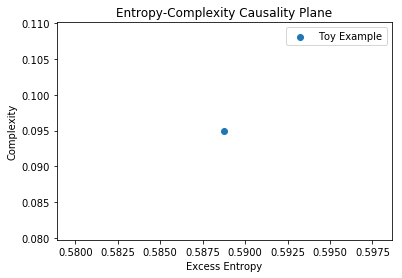

In [180]:
fig, ax = plt.subplots()
ax.set_xlabel('Excess Entropy')
ax.set_ylabel('Complexity')
plt.title('Entropy-Complexity Causality Plane')

plt.scatter(x=excess_entropy,
            y=complexity,
            label='Toy Example')

plt.legend()
plt.show()

Et voila! The sense of this will become clearer when we do this with real data, plotting multiple time series in comparison. 

But for now, here are some examples from Rosso et al showing how algorithms from computer science for various cannonical chaotic and noisy systems lay on this plane:

![Graph](C:\Users\brian\Desktop\Complexity-Entropy-Plane.png)

## An Application to Financial Data

Let's see if we can use this method to quantify the degree of structure within a financial market, with an eye towards sorting them by each market's informational efficiency, and hopefully the market's exploitability by coarse trading strategies.

We'll collate a variety of different sorts of market data, including large & small cap equities, emerging markets, bonds, currency markets, derivative markets, and cryptocurrencies. We'll use log returns on daily Open High Low Close (OHLC) data; for equities, going back 5 years; for crypto, the exchange limits us to data from 2018-01-15. 

When we work with financial price data, we need to be careful to standardize price data of different magnitudes by converting to returns - the percent change day to day - and then ensure statistical normality by working on the log of the cumulative returns, ie log(1 + r).

### Getting the data

The funds & tickers we'll use:

| Type | Fund | Ticker |
| ---- | -----| -----  |
| Large Equity | S&P 500 ETF | SPY |
| Large Equity | Apple | AAPL | 
| Large Equity | Tesla | TSLA |
| Large Equity | 3M | MMM |
| Mid Equity | Vanguard MidCap MF | VIMAX |
| Mid Equity | Crocks | CROX |
| Mid Equity | Magellan Midstream | MMP |
| Small Equity | Vanguard Small Cap MF | VSMAX |  
| Emerging Markets | iShares MSCI Emerging Markets ETF | EEM |
| Bonds | iShares US Treasury Bonds ETF | GOVT | 
| Bonds | iShares Corporate Bond ETF | LQD |
| Bonds | Vanguard Tax-Exempt Bond Index | VTEAX |
| Derivatives | ProShares VIX Mid-Term Futures ETF | VIXM |
| Crypto | Bitcoin | BTC/USDT |
| Crypto | Etherium | ETH/USDT | 
| Crypto | BinanceCoin | BNB/USDT |


For equities & bonds, we'll use the package yfinance to easily pull these tickers' OHLC data from Yahoo Finance. For crypto, we'll pull from Binance using the CCXT package.

Our plan here is to pull Open High Low Close data on a 1 day interval over the past 1 year from some API, then to convert it into daily returns by calculating the percent change day to day. We'll then send the daily returns data through Rosso et al's analysis.

We'll have to treat crypto seperately from the other markets since crypto trades on the weekends & holidays (+ exchange data pull limitations) and so the time series are differently sized, but it would be improper to fillna() in non-crypto markets or drop weekend/holiday records in crypto. Once we analyze each dataset using Rosso et al's method and obtain our ordinal configuration space & probabiliy distributions, we can join the disparate markets back together again.

Let's being by pulling the non-crypto price data and converting to returns:

In [238]:
tickers = ['SPY', 'AAPL', 'TSLA', 'MMM', 'VIMAX', 'CROX', 'MMP', 'VSMAX', 'EEM', 'GOVT', 'LQD', 'VTEAX', 'VIXM']          
crypto_tickers = ['BTC/USDT', 'ETH/USDT', 'BNB/USDT']

In [12]:
prices = yf.download(tickers, period='5y', interval='1d')

[*********************100%***********************]  13 of 13 completed


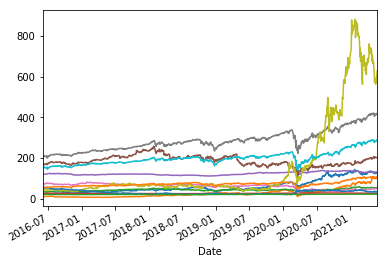

In [13]:
prices['Close'].plot(legend=False)

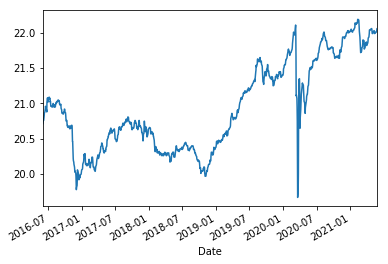

In [234]:
prices['Close','VTEAX'].plot()

In [135]:
# calculate daily returns from Close prices with panda's pct_change()
returns = prices['Close'].pct_change()

log_returns = np.log(returns + 1)

log_returns.head()

,AAPL,CROX,EEM,GOVT,LQD,MMM,MMP,SPY,TSLA,VIMAX,VIXM,VSMAX,VTEAX
Date,,,,,,,,,,,,,
2016-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-01,-0.014119,0.050531,-0.000604,-0.001947,-0.002096,0.002196,0.022863,0.002047,-0.016577,0.002404,-0.007225,0.005579,0.000000
2016-06-02,-0.007544,0.002894,0.008124,0.002724,0.002012,-0.003861,0.007783,0.003039,-0.002736,0.005824,-0.004320,0.006797,0.000483
2016-06-03,0.002045,-0.011628,0.015168,0.006199,0.008009,0.002021,-0.000970,-0.002992,0.000137,-0.004074,-0.004735,-0.004824,0.001929
2016-06-06,0.007225,0.001947,0.010570,-0.001933,-0.002413,0.010046,0.014309,0.005076,0.007688,0.005492,0.001778,0.009803,0.000000


In [136]:
log_returns.tail()

,AAPL,CROX,EEM,GOVT,LQD,MMM,MMP,SPY,TSLA,VIMAX,VIXM,VSMAX,VTEAX
Date,,,,,,,,,,,,,
2021-05-24,0.013226,0.033834,0.008246,0.000759,0.002740,0.003709,0.015413,0.010143,0.043062,0.008842,-0.031692,0.006107,0.000454
2021-05-25,-0.001575,0.015676,0.009843,0.002653,0.003717,-0.004452,-0.023828,-0.002221,-0.002890,-0.004079,0.008689,-0.006873,0.000908
2021-05-26,-0.000394,0.037357,0.007365,-0.000757,-0.000530,-0.000645,0.007188,0.001983,0.023599,0.005574,-0.025991,0.013037,0.000907
2021-05-27,-0.012454,-0.053819,0.000183,-0.000379,-0.003035,0.008201,0.005306,0.000525,0.018753,0.004091,-0.019790,0.008754,0.000000
2021-05-28,-0.002718,-0.007987,0.007856,-0.000189,0.001556,-0.000098,0.003048,0.002763,0.000634,0.000000,-0.008153,0.000000,0.000000


In [235]:
log_returns.std()

AAPL     0.019084
CROX     0.035586
EEM      0.013993
GOVT     0.002737
LQD      0.005519
MMM      0.015677
MMP      0.018732
SPY      0.011947
TSLA     0.037239
VIMAX    0.012831
VIXM     0.021634
VSMAX    0.014285
VTEAX    0.002370
dtype: float64

In [236]:
log_returns.mean()

AAPL     0.001280
CROX     0.001851
EEM      0.000402
GOVT     0.000021
LQD      0.000079
MMM      0.000150
MMP     -0.000280
SPY      0.000552
TSLA     0.002106
VIMAX    0.000502
VIXM    -0.000383
VSMAX    0.000521
VTEAX    0.000050
dtype: float64

Now we're going to grab the crypto data. We'll treat it seperately because it has a different timeframe.

In [138]:
# get crypto data from binance via ccxt
exchange = getattr (ccxt, 'binance') () # create exchange connection

crypto = pd.DataFrame(index=pd.date_range(start=returns.index[0],
                                          end=returns.index[-1],
                                          freq='1d'
                                         )
                     ) # create an empty dataframe to collate our cypto tickers

# we need to grab ohlc data one ticker at a time
for c in crypto_tickers:
    
    # binance only lets us pull 500 records at a time, for a given interval parameter, but we can pull recursively
    # binance also only offers daily data back to 2018-05-29
    # so we'll start there and loop over a fetch_ohlc-append routine until we've grabbed all binance's daily ohlc data for crypto_ticker c
    
    initial_timestamp = 1527552000000 # first daily timestamp binance will serve as of 5/28/2021
    
    coin = pd.DataFrame(exchange.fetch_ohlcv(c, 
                                             '1d', 
                                             since=initial_timestamp
                                            ), 
                        columns=['Timestamp', 'Open', 'High','Low','Close','Volume'])
    
    records = len(coin)
    
    while records == 500:   
        # we'll loop fetch_ohlc and coin.append until our fetch_ohlcv returns < 500 records, in which case we've caught up to the current date
        
        next_pull = pd.DataFrame(exchange.fetch_ohlcv(c, 
                                                 '1d', 
                                                 since=int(coin.loc[coin.index[-1],'Timestamp'])
                                                ), 
                            columns=['Timestamp', 'Open', 'High','Low','Close','Volume'])
        
        coin = coin.append(next_pull, ignore_index=True)
        
        records = len(next_pull)
    
    # convert from timestamp (ms) to utc datetime
    coin.index = (coin['Timestamp'] / 1000).apply(datetime.utcfromtimestamp)
    
    # join onto crypto's datetime index
    crypto = crypto.join(coin['Close'].rename(c))

crypto = crypto[crypto.first_valid_index():] # drop the records at the beginning of our dataframe with all NaN

# calculate the daily returns & log_returns
crypto_returns = crypto.pct_change()
crypto_log_returns = np.log(crypto_returns + 1)

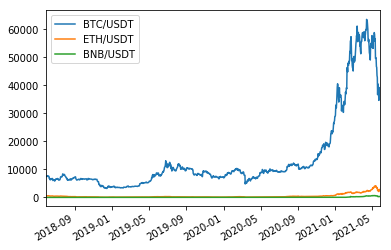

In [141]:
crypto.plot()

In [142]:
crypto_log_returns.head()

,BTC/USDT,ETH/USDT,BNB/USDT
2018-05-29,NaN,NaN,NaN
2018-05-30,-0.011502,-0.018088,0.000999
2018-05-31,0.014676,0.036339,0.117967
2018-06-01,0.004798,0.002057,0.006234
2018-06-02,0.015701,0.020260,0.026547


In [143]:
crypto_log_returns.tail()

,BTC/USDT,ETH/USDT,BNB/USDT
2021-05-24,0.112875,0.233750,0.281951
2021-05-25,-0.012230,0.021176,-0.007143
2021-05-26,0.023650,0.064362,0.099703
2021-05-27,-0.018309,-0.050733,-0.025348
2021-05-28,-0.085175,-0.111284,-0.126082


### Analyzing the data

Let's create a simple function to run Rosso et al's method on these datasets. We could, if we wanted to add additional parameters/options such as alternative entropy or divergence measures, create a class to facilitate passing certain data, but this is straight-forward enough that it doesn't warrant the boilerplate.

We'll pseudo-vectorize the funtion so we can simply pass it the entire time series dataframe, and have it output a dataframe with columns excess entropy and complexity for each financial instrument.

In [296]:
def entropy_complexity(time_series, window=3, diagnostic=False):
    time_series = pd.DataFrame(time_series)
    
    results = pd.DataFrame(columns=['Excess Entropy', 'Complexity'])
    
    if diagnostic:
        results_prob = {}
        results_slices = {}
        results_orders = {}
    
    
    ordinal_values = list(range(1,window + 1))
    permutations = pd.Series(itertools.permutations(ordinal_values))
    
    for c in time_series.columns:
        print(c)
        slices = list(zip(*[time_series[c].dropna().values[i:].tolist() for i in range(window)]))
 
        orders = pd.Series([tuple(scipy.stats.rankdata(s, method='ordinal')) for s in slices], name=c)

        frequencies = pd.value_counts(orders)
        
        probabilities = pd.DataFrame(index=permutations).join(frequencies.rename('Frequencies')).fillna(0)
        probabilities['Probabilities'] = probabilities['Frequencies'] / len(slices)
        probabilities['Uniform'] = 1 / len(probabilities.index)
        
        maximum_entropy = scipy.stats.entropy(probabilities['Uniform'], base=2)
        entropy = scipy.stats.entropy(probabilities['Probabilities'], base=2)
        
        excess_entropy = entropy / maximum_entropy

        divergence = 0.5 * (scipy.stats.entropy((probabilities['Probabilities'] + probabilities['Uniform']) / 2, base=2) \
                        - (scipy.stats.entropy(probabilities['Probabilities'], base=2) / 2) \
                        - (scipy.stats.entropy(probabilities['Uniform'], base=2) / 2))
        complexity = excess_entropy * divergence
        
        results.loc[c] = [excess_entropy, complexity]
        
        if diagnostic:
            results_prob[c] = probabilities
            results_slices[c] = slices
            results_orders[c] = orders
        
    if diagnostic:
        return results, results_prob, results_slices, results_orders
    else:
        return results

It's nice to verify this function works as intended with a known toy example, from above...

In [299]:
results_toy, resprob_toy, resslice_toy, resord_toy = entropy_complexity(time_series,diagnostic=True)
print(results_toy)
resprob_toy

0
   Excess Entropy  Complexity
0        0.588762    0.094939


{0:            Frequencies  Probabilities   Uniform
 (1, 2, 3)          2.0            0.4  0.166667
 (1, 3, 2)          0.0            0.0  0.166667
 (2, 1, 3)          1.0            0.2  0.166667
 (2, 3, 1)          2.0            0.4  0.166667
 (3, 1, 2)          0.0            0.0  0.166667
 (3, 2, 1)          0.0            0.0  0.166667}

Run on our real financial data and combine results...

In [195]:
equity_results = entropy_complexity(log_returns)
crypto_results = entropy_complexity(crypto_log_returns)

results = equity_results.append(crypto_results)

results

,Excess Entropy,Complexity
AAPL,0.999539,0.000150
CROX,0.998380,0.000525
EEM,0.998474,0.000493
GOVT,0.998944,0.000341
LQD,0.999596,0.000131
MMM,0.998406,0.000515
MMP,0.998009,0.000644
SPY,0.998353,0.000541
TSLA,0.999763,0.000076
VIMAX,0.997447,0.000843


Now let's plot these results:

In [226]:
# i want to grab the sector type for plot markers
ticker_info = pd.DataFrame([['Large Equity','S&P 500 ETF','SPY','o', 'r'],
                ['Large Equity','Apple','AAPL','o', 'b'],
                ['Large Equity','Tesla','TSLA','o', 'g'],
                ['Large Equity','3M','MMM','o','y'],
                ['Mid Equity','Vanguard MidCap MF','VIMAX','.','m'],
                ['Mid Equity','Crocks','CROX', '.','c'],
                ['Mid Equity','Magellan Midstream','MMP','.','k'],
                ['Small Equity','Vanguard Small Cap MF','VSMAX',',','k'], 
                ['Emerging Markets','iShares MSCI Emerging Markets ETF','EEM','1','r'],
                ['Bonds','iShares US Treasury Bonds ETF','GOVT','s','b'],
                ['Bonds','iShares Corporate Bond ETF','LQD','s','g'],
                ['Bonds','Vanguard Tax-Exempt Bond Index','VTEAX','s','r'],
                ['Derivatives','ProShares VIX Mid-Term Futures ETF','VIXM','*','m'],
                ['Crypto','Bitcoin','BTC/USDT','D','c'],
                ['Crypto','Etherium','ETH/USDT','D','m'],
                ['Crypto','BinanceCoin','BNB/USDT','D','y']],
            columns=['Sector', 'Description', 'Ticker', 'Marker','Color'])
ticker_info.index = ticker_info['Ticker']

In [227]:
ticker_info

,Sector,Description,Ticker,Marker,Color
Ticker,,,,,
SPY,Large Equity,S&P 500 ETF,SPY,o,r
AAPL,Large Equity,Apple,AAPL,o,b
TSLA,Large Equity,Tesla,TSLA,o,g
MMM,Large Equity,3M,MMM,o,y
VIMAX,Mid Equity,Vanguard MidCap MF,VIMAX,.,m
CROX,Mid Equity,Crocks,CROX,.,c
MMP,Mid Equity,Magellan Midstream,MMP,.,k
VSMAX,Small Equity,Vanguard Small Cap MF,VSMAX,",",k
EEM,Emerging Markets,iShares MSCI Emerging Markets ETF,EEM,1,r


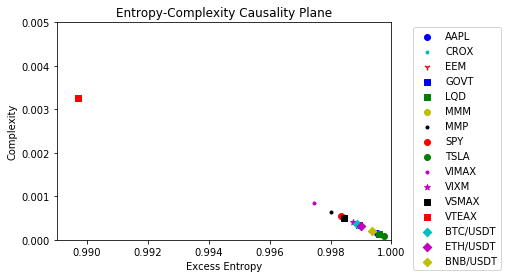

In [241]:
fig, ax = plt.subplots()
ax.set_xlabel('Excess Entropy')
ax.set_ylabel('Complexity')
plt.title('Entropy-Complexity Causality Plane')

# we'll loop over the results so we can specify markers for each financial sector
for t in results.index:
    plt.scatter(x=results.loc[t, 'Excess Entropy'],
                y=results.loc[t, 'Complexity'],
                marker=ticker_info.loc[t, 'Marker'],
                color=ticker_info.loc[t, 'Color'],
                label=t)
    
# set some axis limits to size the plot appropriately
plt.xlim(0.989,1)
plt.ylim(0,0.005)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

We can see our results very roughly match those of Rosso et al! Most markets are near informational equilibrium, where there is no signal in the returns series exploitable by traders, with high excess entropy and relatively low complexity. One ticker - VTEAX, Vanguard's tax exempt bonds ETF - displays the entropic signature of a higher degree of internal structure.

[what's the explanation for this? other metrics that are weird? std.dev was weirdly low. what gives?]

Let's exclude the outlier and zoom in on the bottom right corner:

In [249]:
results#.drop('VTEAX')

,Excess Entropy,Complexity
AAPL,0.999539,0.000150
CROX,0.998380,0.000525
EEM,0.998474,0.000493
GOVT,0.998944,0.000341
LQD,0.999596,0.000131
MMM,0.998406,0.000515
MMP,0.998009,0.000644
SPY,0.998353,0.000541
TSLA,0.999763,0.000076
VIMAX,0.997447,0.000843


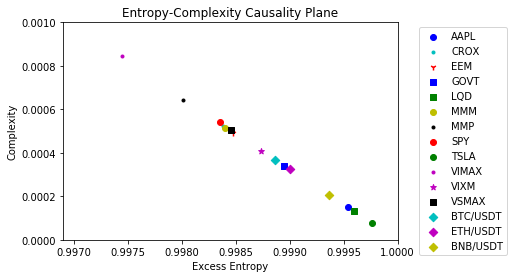

In [260]:
fig, ax = plt.subplots()
ax.set_xlabel('Excess Entropy')
ax.set_ylabel('Complexity')
plt.title('Entropy-Complexity Causality Plane')

# we'll loop over the results so we can specify markers for each financial sector
for t in results.index:
    if t != 'VTEAX':
        plt.scatter(x=results.loc[t, 'Excess Entropy'],
                        y=results.loc[t, 'Complexity'],
                        marker=ticker_info.loc[t, 'Marker'],
                        color=ticker_info.loc[t, 'Color'],
                        label=t)
    
# set some axis limits to size the plot appropriately, eyeballed & hardcoded
plt.xlim(0.9969,1)
plt.ylim(0,0.001)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

this doesnt match my hypothesis
why is tesla, in a wild bubble, nearest to noise? spy not near noise? idk, can we impute sense to this? it's def not market cap=liquidity, lqd is small. maybe, like, velocity of money? presence of retail traders? or maybe the representation plane is bullshit lol

let's try again with window=5

In [281]:
equity_results5 = entropy_complexity(log_returns,window=5)
crypto_results5 = entropy_complexity(crypto_log_returns,window=5)

results5 = equity_results5.append(crypto_results5)

results5

,Excess Entropy,Complexity
AAPL,0.991405,0.007535
CROX,0.988621,0.010030
EEM,0.991305,0.007516
GOVT,0.990267,0.008334
LQD,0.988686,0.009929
MMM,0.989939,0.008749
MMP,0.987244,0.011210
SPY,0.988365,0.010290
TSLA,0.991214,0.007650
VIMAX,0.989266,0.009369


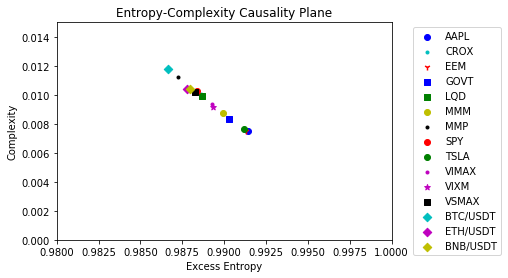

In [344]:
fig, ax = plt.subplots()
ax.set_xlabel('Excess Entropy')
ax.set_ylabel('Complexity')
plt.title('Entropy-Complexity Causality Plane')

# we'll loop over the results so we can specify markers for each financial sector
for t in results5.index:
    if t != 'VTEAX':
        plt.scatter(x=results5.loc[t, 'Excess Entropy'],
                        y=results5.loc[t, 'Complexity'],
                        marker=ticker_info.loc[t, 'Marker'],
                        color=ticker_info.loc[t, 'Color'],
                        label=t)
    
# set some axis limits to size the plot appropriately, eyeballed & hardcoded
plt.xlim(0.98,1)
plt.ylim(0,0.015)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

idk nothings different. dress the speculation up fancy and shrug my sholders.

write a simple little macd backtest and be like "look the trading results don't match the representation, null hypothesis wins nothing here. speculation on why this is a bad idea (non-orthogonal basis, data occupies a highly restricted subplane, quantitative info less important than structural, etcidk "

In [325]:
ma12 = prices['Close'].rolling(12).mean()
ma26 = prices['Close'].rolling(26).mean()

# let's "run the strategy" by checking where the 12-day moving average is above the 2-day moving average (ie, price is increasing/accelerating)
# and compute our returns by summing the log prices here 

# we're holding the security whenever ma12 > ma26
long = ma12 > ma26
# the macd indicator, positive when ma12 > ma26 & negative when ma12 < ma26
macd = ma12 - ma26

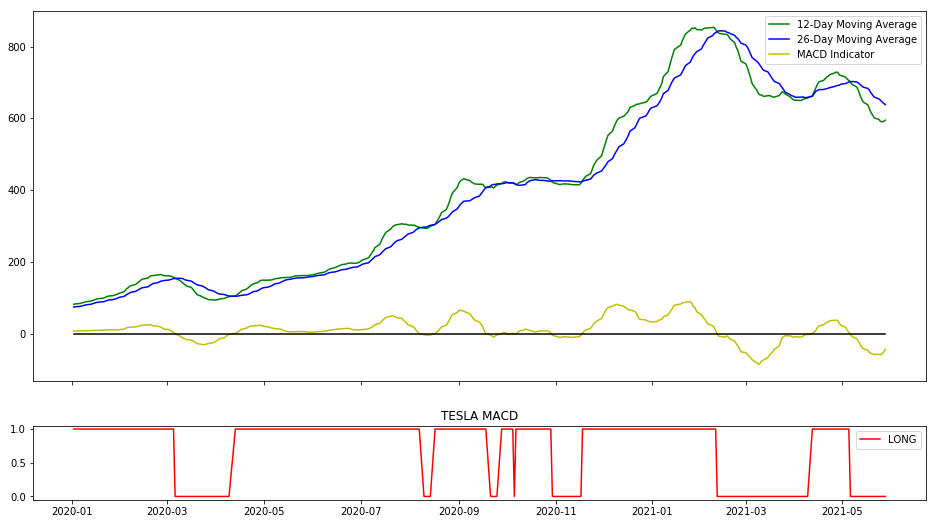

In [351]:
fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,9), gridspec_kw={'height_ratios': [3, 0.6]})

ax.plot(ma12.loc[pd.to_datetime('2020-01-01'):,'TSLA'], color='g', label='12-Day Moving Average')
ax.plot(ma26.loc[pd.to_datetime('2020-01-01'):,'TSLA'],color='b', label='26-Day Moving Average')
ax.plot(macd.loc[pd.to_datetime('2020-01-01'):,'TSLA'],color='y', label='MACD Indicator')
ax.plot(pd.Series(0,index=macd.loc[pd.to_datetime('2020-01-01'):,'TSLA'].index), color='k')


ax2.plot(long.loc[pd.to_datetime('2020-01-01'):,'TSLA'],color='r', label='LONG')

ax.legend()
ax2.legend()
plt.title('TESLA MACD')
plt.show()

To get our cumulative (log) returns, we just sum the log returns for the periods where we're long a security:

In [402]:
cumulative_returns = log_returns[long].sum()

cumulative_returns

AAPL     1.484082
CROX     2.761662
EEM      0.542782
GOVT     0.063479
LQD      0.034563
MMM     -0.262080
MMP      0.200480
SPY      0.502456
TSLA     2.828819
VIMAX    0.515657
VIXM     0.310758
VSMAX    0.427289
VTEAX    0.056765
dtype: float64

Let's plot the values our portfolio would have over time if we gave each MACD bot $1000 to trade with:

In [425]:
portfolio_value = (log_returns[long]).cumsum().fillna(method='ffill').fillna(0)

portfolio_dollars = (portfolio_value + 1) * 1000

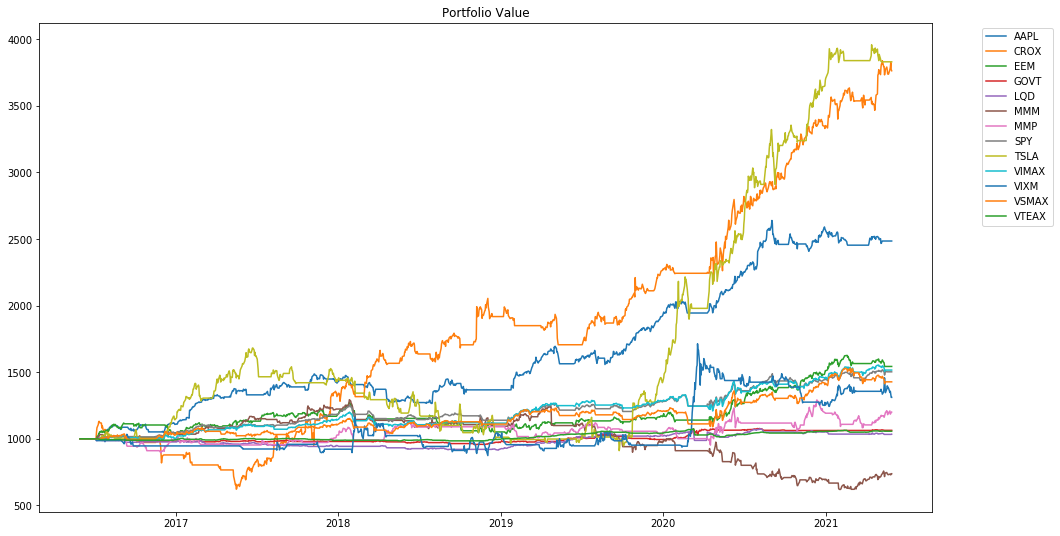

In [433]:
fig, ax = plt.subplots(figsize=(16,9))
plt.title('Portfolio Value')

# we'll loop over the results so we can specify markers for each financial sector
plt.plot(portfolio_dollars, label=portfolio_dollars.columns)

plt.legend(portfolio_dollars.columns, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [421]:
daily_sharpe = returns[long].mean() / returns[long].std()
annual_sharpe = daily_sharpe * np.sqrt(252)

annual_sharpe

AAPL     1.844678
CROX     1.920118
EEM      1.098503
GOVT     0.583162
LQD      0.228623
MMM     -0.320035
MMP      0.514308
SPY      1.208643
TSLA     2.007834
VIMAX    1.145531
VIXM     0.594644
VSMAX    0.872689
VTEAX    0.804354
dtype: float64

Let's compare our risk-adjusted returns to our excess entropy x complexity representation to see if either dimension correlates with our MACD Sharpe ratios.

In [450]:
trading_results = pd.concat((equity_results, annual_sharpe.rename('Annual Sharpe')), axis=1)

trading_results.sort_values(by='Annual Sharpe', ascending=False)

,Excess Entropy,Complexity,Annual Sharpe
TSLA,0.999763,0.000076,2.007834
CROX,0.998380,0.000525,1.920118
AAPL,0.999539,0.000150,1.844678
SPY,0.998353,0.000541,1.208643
VIMAX,0.997447,0.000843,1.145531
EEM,0.998474,0.000493,1.098503
VSMAX,0.998454,0.000505,0.872689
VTEAX,0.989689,0.003258,0.804354
VIXM,0.998736,0.000408,0.594644
GOVT,0.998944,0.000341,0.583162


And there is basically no correlation between either excess entropy or complexity and our MACD annual Sharpe ratio. The correlation is basically the same for both, though flipped sign, because the empirical values fall on a straight line with slope of roughly -1 due to the non-orthogonality of the basis.

In [451]:
trading_results['Excess Entropy'].corr(trading_results['Annual Sharpe'])

0.12134271039614263

In [452]:
trading_results['Complexity'].corr(trading_results['Annual Sharpe'])

-0.12141967959415349

This is sort of the final defeat of our hypothesis, at least for me. The securities that are less random didn't match our expecttions, and didn't perform better in a simple trading test. This exhausts the financial value of this for me, but hopefully there was some pedagogical value in the programming exercise.

My key philosophical concern with this representation is that the principle axes - Complexity and Excess Entropy - are clearly non-orthogonal. Indeed, their Complexity measure includes its abscissa as a component term: Complexity = Jensen-Shannon Divergence * Excess Entropy. As a result, the dynamics of this representation - the possible locations of a time series within this representational plane - are confined to a small subplane, the narrow curved band coverging into the bottom right corner we see in the image from Rosso et al above. 

Philosophically, I believe that an ontology or representational scheme is information-theoretically optimal when the dynamics of the system so conceptualized ergodically span the full range of the configuration space. This means our concepts encode the most possible information about the dynamics of our system, we've cleved nature at its joints, or something like it. That the time series dynamics playing out on the representational plane of Rosso et al are confined to a subspace means we've yet to fully disentangle the conceptual tangles of complexity, chaos, and information. 